In [2]:
#Импорт библиотек

import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.tree as tree
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import random
%matplotlib inline
from scipy import stats

In [3]:
#Расчет Somers D

def somers_d(xx,yy,weight = None):
    
    '''
    xx - feature
    yy - target
    weight - weights
    '''
    
    if weight is None: weight = np.ones(len(xx))

    x = st.rankdata(xx)
    y = st.rankdata(yy)
    weight = np.array(weight)
    
    n2_const = sum(weight[:-1]*(sum(weight)-np.cumsum(weight[:-1])))
    K, y_adj = 0, 0

    for i in range(len(weight)-1):
        sign_arr_x = np.sign(x[i]-x[i+1:len(weight)])
        sign_arr_y = np.sign(y[i]-y[i+1:len(weight)])
        ww_arr = weight[i]*weight[i+1:]

        K += sum(ww_arr*sign_arr_x*sign_arr_y)
        y_adj += sum(ww_arr*(1 - abs(sign_arr_y*sign_arr_y)))
        
    return K/(n2_const-y_adj)

In [4]:
#Расчет Псевдо r2

def pseudo_rsq_binary(y,p,weight = None):
    
    if weight is None: weight = np.ones(len(y))

    LogL = 0;
    LogL_mean = 0;
    
    for i in range(len(weight)):
        LogL += weight[i]*(y[i]*np.log(p[i]) + (1-y[i])*np.log(1-p[i]));
        LogL_mean += weight[i]*(y[i]*np.log(np.mean(y)) + (1-y[i])*np.log(1-np.mean(y)));
        
    return 1 - LogL/LogL_mean

In [26]:
a = pd.read_excel(io='Data_LGD_home.xlsx',sheet_name='LGD_dataset');
a.head()

,ID,INN,DNW,LGD_target,D_last date,DNW_D,Fact_spis,x1,x2,x3,...,x6,x7,x8,x9,x10,x11,x12,x13,x14,Bootstrap
0,1,1006004155,1,0.0,0,748062,0,9322584,-281640,6528167,...,0.271262,0.194722,-0.528777,0.700253,0.386323,0.725605,11,1,0,1
1,2,1101061763,1,1.0,74655,18333,1,692498,18371,3345219,...,0.813498,0.593327,-0.138757,4.830655,0.376312,0.743998,14,1,0,2
2,4,1216012466,1,1.0,148912,55442,1,790750,3039,1593880,...,1.101191,0.617063,0.086615,2.015656,0.053444,0.855961,11,0,0,1
3,10,1435090883,1,0.0,0,24060,0,592232,-9205,1255417,...,1.897815,0.715997,0.454641,2.119806,0.024590,0.506386,13,1,0,2
4,11,1646022089,1,0.0,0,715948,0,2163905,-359490,2762999,...,0.734451,0.125916,-0.307985,1.276858,0.029794,1.159806,3,3,0,2


In [27]:
#Результаты однофакторного анализа для целевой переменной Fact_spis
SF_analysis_Fact_spis = np.array([-somers_d(a.x1,a.Fact_spis,weight = None),-somers_d(a.x2,a.Fact_spis,weight = None),
-somers_d(a.x3,a.Fact_spis,weight = None),somers_d(a.x4,a.Fact_spis,weight = None),-somers_d(a.x5,a.Fact_spis,weight = None),
-somers_d(a.x6,a.Fact_spis,weight = None),-somers_d(a.x7,a.Fact_spis,weight = None),-somers_d(a.x8,a.Fact_spis,weight = None),
-somers_d(a.x9,a.Fact_spis,weight = None),-somers_d(a.x10,a.Fact_spis,weight = None),somers_d(a.x11,a.Fact_spis,weight = None),
-somers_d(a.x12,a.Fact_spis,weight = None),-somers_d(a.x13,a.Fact_spis,weight = None),-somers_d(a.x14,a.Fact_spis,weight = None)]);
print(SF_analysis_Fact_spis);

[-0.00704706 -0.08842919  0.07888156 -0.00159127 -0.05114799  0.02932485
  0.04160036 -0.00431916  0.0093203   0.10206865  0.09433962 -0.04205501
 -0.04501023 -0.03932712]


In [ ]:
#Вывод - модели регрессии не подходят для разработки из-за малости Somers'D по большинству риск-факторов, поэтому требуются модели деревянной структуры

In [28]:
#Кросс-валидация модели исходов (для определения перечня переменных, работающих стабильнее всего, с целью исключения переобучения модели)
#Исключаются переменные с отрицательным значением коэффициента Джини с переменной Fact_spis, так как они вносят нестабильность в модели


max_int = 11; #Больше 10 глубины на практике без переобучения не бывает
cv_scores = [];

for i in range (1, max_int):
    d_tree = tree.DecisionTreeClassifier(max_depth = i, min_samples_leaf = 12, min_impurity_decrease = 0.000001)
    scores = cross_val_score(d_tree,pd.DataFrame(np.array([a.x3,a.x6,a.x7,a.x9,a.x10,a.x11]).transpose()),a.Fact_spis, cv = 4, scoring = 'roc_auc')
    cv_scores.append(2*scores.mean()-1)
    
print("Значения коэффициента Джини на кросс-валидации для дерева =",cv_scores);

Значения коэффициента Джини на кросс-валидации для дерева = [-0.0032509157509157394, -0.040247252747252604, -0.01840659340659334, -0.07847985347985342, -0.03727106227106236, -0.0198717948717948, -0.03727106227106236, -0.03727106227106236, -0.08672161172161164, -0.03727106227106236]


In [29]:
#Разработка модели списаний на основе дерева классификации - формирование первичных данных для разработки (для исключения переобучения убираем факторы с отрицательным Джини для модели Исходов и оставляем переменные, наиболее точно работающие на кросс-валидации)

#rsh = pd.DataFrame(np.array([a.x1,a.x2,a.x3,a.x4,a.x5,a.x6,a.x7,a.x8,a.x9,a.x10,a.x11,a.x12,a.x13,a.x14]).transpose());
rsh = pd.DataFrame(np.array([a.x3,a.x6,a.x7,a.x9,a.x10,a.x11]).transpose());
print(rsh);

             0         1         2         3         4         5
0    6528167.0  0.271262  0.194722  0.700253  0.386323  0.725605
1    3345219.0  0.813498  0.593327  4.830655  0.376312  0.743998
2    1593880.0  1.101191  0.617063  2.015656  0.053444  0.855961
3    1255417.0  1.897815  0.715997  2.119806  0.024590  0.506386
4    2762999.0  0.734451  0.125916  1.276858  0.029794  1.159806
..         ...       ...       ...       ...       ...       ...
131  1266060.0  0.752016  0.224346  1.369700  0.277769  0.886802
132  8025028.0  1.511631  0.917868  0.999548  0.277444  0.275023
133  4184605.0  0.738553  0.637169  0.852526  0.322493  0.902127
134  1031381.0  0.433356  0.269649  0.146110  0.741103  0.194558
135  4995424.0  0.353159  0.283866  1.236278  0.711680  0.740945

[136 rows x 6 columns]


In [30]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше

clf = tree.DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.000001);
clf_fit = clf.fit(rsh,a.Fact_spis);
clf_fit_score = clf_fit.score(rsh,a.Fact_spis)

In [31]:
#Somers'D полученной модели исходов
somers_d(clf_fit.predict_proba(rsh)[:,1],a.Fact_spis,weight = None)

0.4394180495567174

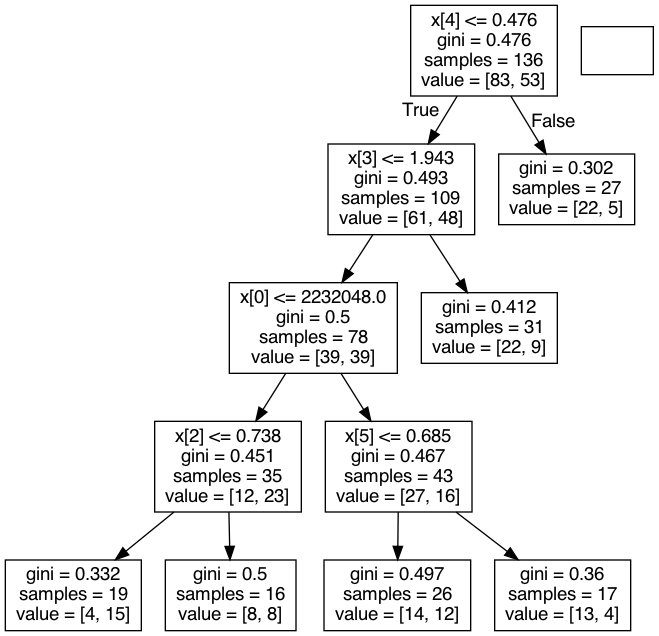

In [32]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [ ]:
#x[5] (a.x11) работает в дереве неинтерпретируемо. Поэтому переменная эта уходит из анализа

In [33]:
#Разработка модели списаний на основе дерева классификации - формирование первичных данных для разработки (для исключения переобучения убираем факторы с отрицательным Джини для модели Исходов и оставляем переменные, наиболее точно работающие на кросс-валидации)

#rsh = pd.DataFrame(np.array([a.x1,a.x2,a.x3,a.x4,a.x5,a.x6,a.x7,a.x8,a.x9,a.x10,a.x11,a.x12,a.x13,a.x14]).transpose());
rsh = pd.DataFrame(np.array([a.x3,a.x6,a.x7,a.x9,a.x10]).transpose());
print(rsh);

             0         1         2         3         4
0    6528167.0  0.271262  0.194722  0.700253  0.386323
1    3345219.0  0.813498  0.593327  4.830655  0.376312
2    1593880.0  1.101191  0.617063  2.015656  0.053444
3    1255417.0  1.897815  0.715997  2.119806  0.024590
4    2762999.0  0.734451  0.125916  1.276858  0.029794
..         ...       ...       ...       ...       ...
131  1266060.0  0.752016  0.224346  1.369700  0.277769
132  8025028.0  1.511631  0.917868  0.999548  0.277444
133  4184605.0  0.738553  0.637169  0.852526  0.322493
134  1031381.0  0.433356  0.269649  0.146110  0.741103
135  4995424.0  0.353159  0.283866  1.236278  0.711680

[136 rows x 5 columns]


In [35]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше

clf = tree.DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.000001);
clf_fit = clf.fit(rsh,a.Fact_spis);
clf_fit_score = clf_fit.score(rsh,a.Fact_spis)

In [36]:
#Somers'D полученной модели исходов
somers_d(clf_fit.predict_proba(rsh)[:,1],a.Fact_spis,weight = None)

0.4310070470561491

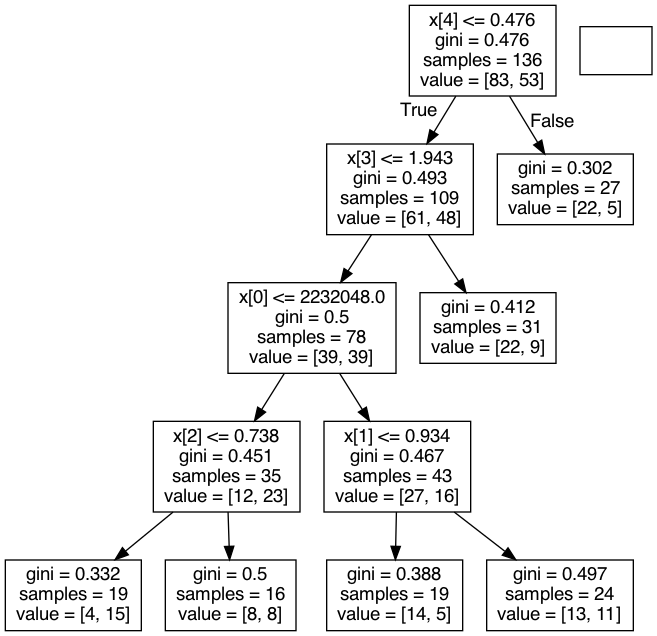

In [37]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [ ]:
#x[1] (a.x6) работает в дереве неинтерпретируемо. Поэтому переменная эта уходит из анализа

In [38]:
#Разработка модели списаний на основе дерева классификации - формирование первичных данных для разработки (для исключения переобучения убираем факторы с отрицательным Джини для модели Исходов и оставляем переменные, наиболее точно работающие на кросс-валидации)

#rsh = pd.DataFrame(np.array([a.x1,a.x2,a.x3,a.x4,a.x5,a.x6,a.x7,a.x8,a.x9,a.x10,a.x11,a.x12,a.x13,a.x14]).transpose());
rsh = pd.DataFrame(np.array([a.x3,a.x7,a.x9,a.x10]).transpose());
print(rsh);

             0         1         2         3
0    6528167.0  0.194722  0.700253  0.386323
1    3345219.0  0.593327  4.830655  0.376312
2    1593880.0  0.617063  2.015656  0.053444
3    1255417.0  0.715997  2.119806  0.024590
4    2762999.0  0.125916  1.276858  0.029794
..         ...       ...       ...       ...
131  1266060.0  0.224346  1.369700  0.277769
132  8025028.0  0.917868  0.999548  0.277444
133  4184605.0  0.637169  0.852526  0.322493
134  1031381.0  0.269649  0.146110  0.741103
135  4995424.0  0.283866  1.236278  0.711680

[136 rows x 4 columns]


In [39]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше

clf = tree.DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.006);
clf_fit = clf.fit(rsh,a.Fact_spis);
clf_fit_score = clf_fit.score(rsh,a.Fact_spis)

In [40]:
#Somers'D полученной модели исходов
somers_d(clf_fit.predict_proba(rsh)[:,1],a.Fact_spis,weight = None)

0.40350079563537167

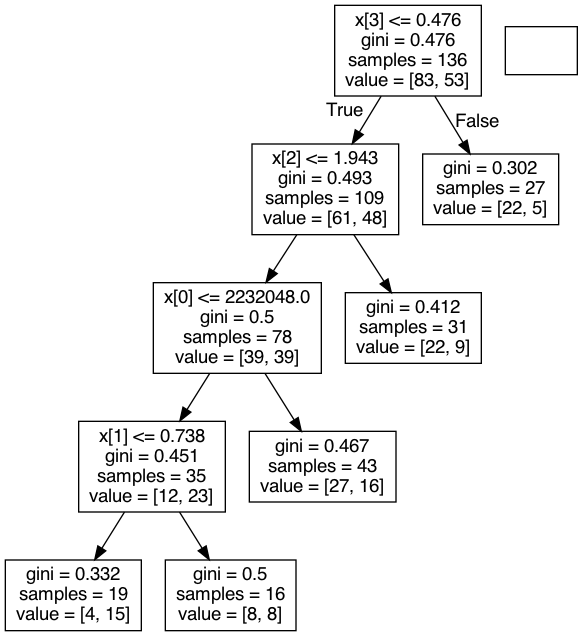

In [41]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [42]:
#Кросс-валидация модели исходов (для определения оптимальной итоговой глубины дерева с целью исключения переобучения модели)

max_int = 11;
cv_scores = [];

for i in range (1, max_int):
    d_tree = tree.DecisionTreeClassifier(max_depth = i, min_samples_leaf = 12, min_impurity_decrease = 0.006)
    scores = cross_val_score(d_tree,pd.DataFrame(np.array([a.x3,a.x7,a.x9,a.x10]).transpose()),a.Fact_spis, cv = 4, scoring = 'roc_auc')
    cv_scores.append(2*scores.mean()-1)
    
print("Значения коэффициента Джини на кросс-валидации для дерева =",cv_scores);
best = 4 #почти оптимальное значение коэффициента Джини на кросс-валидации, сопоставимо с глубиной 1 (точность на кросс-валидации сопотавима)
print("Оптимальная глубина дерева =", best)

Значения коэффициента Джини на кросс-валидации для дерева = [-0.04629120879120885, -0.08420329670329663, -0.02596153846153837, -0.06233974358974359, -0.05135073260073264, -0.05135073260073264, -0.05135073260073264, -0.05135073260073264, -0.05135073260073264, -0.05135073260073264]
Оптимальная глубина дерева = 4


In [43]:
#Вывод итогового дерева для модели исходов на основе дерева классификации с оптимальной глубиной = 3 на кросс-валидации
clf = tree.DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 16, min_impurity_decrease = 0.006);
clf_fit = clf.fit(rsh,a.Fact_spis);
clf_fit_score = clf_fit.score(rsh,a.Fact_spis)

In [44]:
somers_d(clf_fit.predict_proba(rsh)[:,1],a.Fact_spis,weight = None)

0.40350079563537167

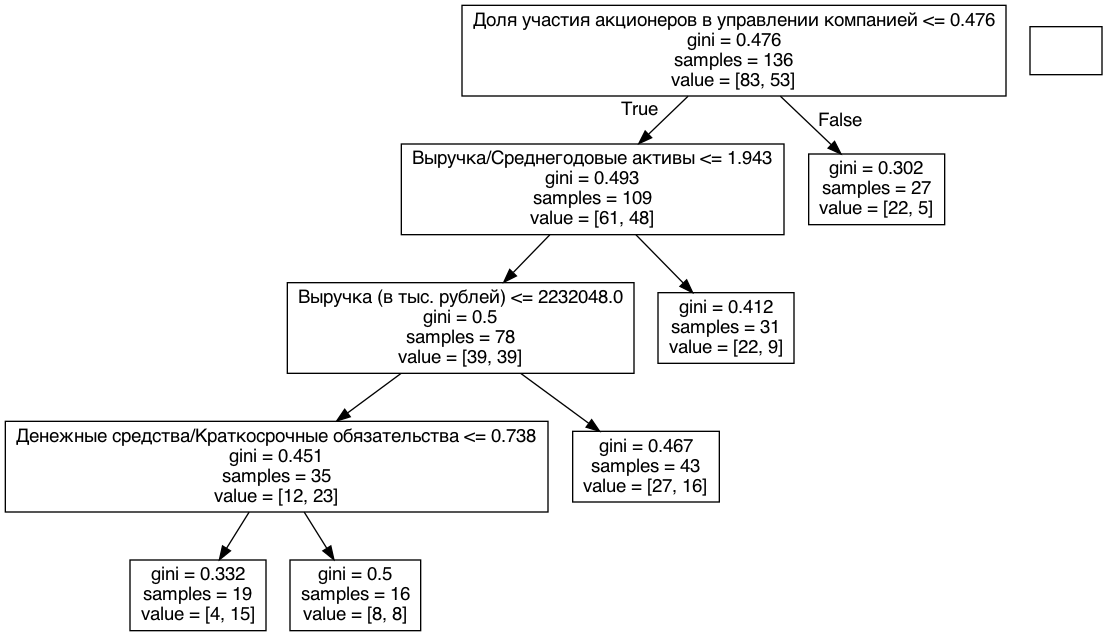

In [45]:
#Визуализация итогового дерева модели исходов

dot_data = tree.export_graphviz(clf,out_file=None,feature_names=['Выручка (в тыс. рублей)','Денежные средства/Краткосрочные обязательства','Выручка/Среднегодовые активы','Доля участия акционеров в управлении компанией']);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [46]:
#Характеристики итоговой модели исходов
print("Количество наблюдений в исходной выборке =", a.x1.shape[0]);
print("Значимость весов риск-факторов в модели =",clf_fit.feature_importances_);
print("Значение коэффициента Somers'D модели =", somers_d(pd.DataFrame(clf_fit.predict_proba(rsh)[:,1]),a.Fact_spis,weight = None));
print("Значение коэффициента Somers'D на кросс-валидации =",cv_scores[2]);
print("Значение коэффициента Псевдо r2 =",pseudo_rsq_binary(np.array(a.Fact_spis),np.array(clf_fit.predict_proba(rsh)[:,1]),weight = None))

Количество наблюдений в исходной выборке = 136
Значимость весов риск-факторов в модели = [0.33499367 0.15551663 0.2083945  0.3010952 ]
Значение коэффициента Somers'D модели = 0.40350079563537167
Значение коэффициента Somers'D на кросс-валидации = -0.02596153846153837
Значение коэффициента Псевдо r2 = 0.11071313895708179


In [7]:
#Загрузка исходных данных для модели оценки потерь при списании 

a1 = pd.read_excel(io='Data_LGD_home.xlsx',sheet_name='LGD_dataset_spis');
a1.head()

,ID,INN,DNW,LGD_target,D_last date,DNW_D,Fact_spis,x1,x2,x3,...,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,2,1101061763,1,1.0,74655,18333,1,692498,18371,3345219,...,0.026529,0.813498,0.593327,-0.138757,4.830655,0.376312,0.743998,14,1,0
1,4,1216012466,1,1.0,148912,55442,1,790750,3039,1593880,...,0.003843,1.101191,0.617063,0.086615,2.015656,0.053444,0.855961,11,0,0
2,15,1651052843,1,1.0,298105,14532,1,274893,10779,1162812,...,0.039212,1.186951,0.610366,0.153551,4.230053,0.025104,0.821341,4,1,0
3,17,2126001687,1,1.0,118594768,835951,1,12549398,-792431,3149146,...,-0.063145,0.509579,0.373729,-0.166206,0.250940,0.187556,0.338905,20,0,0
4,18,2126003074,1,1.0,128660773,8422,1,15532238,-945347,4348189,...,-0.060864,1.242426,1.089182,0.118648,0.279946,0.273073,0.489420,20,0,0


In [9]:
#Результаты однофакторного анализа для целевой переменной LGD_target на выборке модели оценки потерь при списании
SF_analysis_LGD_target_spis = np.array([-somers_d(a1.x1,a1.LGD_target,weight = None),-somers_d(a1.x2,a1.LGD_target,weight = None),
-somers_d(a1.x3,a1.LGD_target,weight = None),somers_d(a1.x4,a1.LGD_target,weight = None),-somers_d(a1.x5,a1.LGD_target,weight = None),
-somers_d(a1.x6,a1.LGD_target,weight = None),-somers_d(a1.x7,a1.LGD_target,weight = None),-somers_d(a1.x8,a1.LGD_target,weight = None),
-somers_d(a1.x9,a1.LGD_target,weight = None),-somers_d(a1.x10,a1.LGD_target,weight = None),somers_d(a1.x11,a1.LGD_target,weight = None),
-somers_d(a1.x12,a1.LGD_target,weight = None),-somers_d(a1.x13,a1.LGD_target,weight = None),-somers_d(a1.x14,a1.LGD_target,weight = None)]);
print(SF_analysis_LGD_target_spis);

[-0.20116618 -0.31778426 -0.14868805  0.09620991 -0.39941691 -0.32944606
 -0.24198251 -0.34110787  0.11370262  0.25947522 -0.31778426  0.1516035
  0.17492711 -0.08163265]


In [10]:
#Кросс-валидация модели потерь (для определения перечня переменных, работающих стабильнее всего, с целью исключения переобучения модели)
#Исключаются переменные с отрицательным значением коэффициента Джини с переменной LGD_target_spis, так как они вносят нестабильность в модели

max_int_1 = 11;
cv_scores_1 = [];

for i in range (1, max_int_1):
    d_tree_1 = tree.DecisionTreeRegressor(max_depth = i, min_samples_leaf = 12, min_impurity_decrease = 0.000001)
    scores_1 = cross_val_score(d_tree_1,pd.DataFrame(np.array([a1.x4,a1.x9,a1.x10,a1.x12,a1.x13]).transpose()),a1.LGD_target, cv = 4, scoring = 'r2')
    cv_scores_1.append(scores_1.mean())
    
print("Значения коэффициента r2 на кросс-валидации для решающего дерева =",cv_scores_1);

Значения коэффициента r2 на кросс-валидации для решающего дерева = [-0.7902231173170056, -0.9425907881510194, -0.8843708576653636, -0.9478535527477164, -0.9477132204633508, -0.9425907881510184, -0.8843708576653628, -0.9477132204633517, -0.9425907881510185, -0.8843708576653637]


In [11]:
#Разработка модели модели оценки потерь при списании - исходные данные для разработки

#rsh_1 = pd.DataFrame(np.array([a1.x1,a1.x2,a1.x3,a1.x4,a1.x5,a1.x6,a1.x7,a1.x8,a1.x9,a1.x10,a1.x11,a1.x12,a1.x13,a1.x14]).transpose());
rsh_1 = pd.DataFrame(np.array([a1.x4,a1.x9,a1.x10,a1.x12,a1.x13]).transpose());
print(rsh_1);

             0         1         2     3    4
0     522437.0  4.830655  0.376312  14.0  1.0
1     781633.0  2.015656  0.053444  11.0  0.0
2     228049.0  4.230053  0.025104   4.0  1.0
3   11826202.0  0.250940  0.187556  20.0  0.0
4   14208577.0  0.279946  0.273073  20.0  0.0
5   11512763.0  0.752649  0.065850  14.0  1.0
6    1210036.0  1.432562  0.298483  18.0  4.0
7    1256778.0  0.929664  0.132179   7.0  0.0
8    2899078.0  0.347986  0.687995   3.0  1.0
9    2217289.0  1.294182  0.106488  16.0  1.0
10   4961173.0  0.319566  0.257653   8.0  2.0
11   2533324.0  1.094455  0.474786  14.0  2.0
12   2310881.0  1.642264  0.613196   5.0  2.0
13    845947.0  1.251726  0.236234   9.0  1.0
14   4979037.0  0.432888  0.079229  13.0  1.0
15   3870057.0  0.486763  0.235998  12.0  1.0
16    833752.0  1.269591  0.089148   9.0  2.0
17   8232166.0  0.402039  0.829200  22.0  1.0
18   1950305.0  2.526788  0.001608   9.0  1.0
19   3713981.0  1.608086  0.099775  14.0  1.0
20   4793376.0  0.438147  0.444686

In [12]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше

clf_1 = tree.DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.000001);
clf_fit_1 = clf_1.fit(rsh_1,a1.LGD_target);
clf_fit_score_1 = clf_fit_1.score(rsh_1,a1.LGD_target)

In [13]:
#R2 полученной модели
clf_fit_score_1

0.09159800605917168

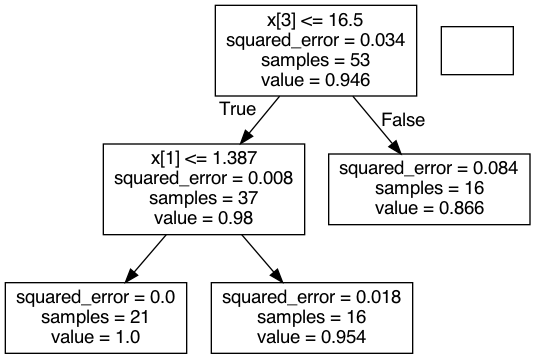

In [14]:
#Визуализация текущей модели оценки потерь при списании 

dot_data_1 = tree.export_graphviz(clf_1,out_file=None);
graph_1 = pydotplus.graph_from_dot_data(dot_data_1);
Image(graph_1.create_png())

In [15]:
#Разработка модели модели оценки потерь при списании - исходные данные для разработки

#rsh_1 = pd.DataFrame(np.array([a1.x1,a1.x2,a1.x3,a1.x4,a1.x5,a1.x6,a1.x7,a1.x8,a1.x9,a1.x10,a1.x11,a1.x12,a1.x13,a1.x14]).transpose());
rsh_1 = pd.DataFrame(np.array([a1.x9,a1.x12]).transpose());
print(rsh_1);

           0     1
0   4.830655  14.0
1   2.015656  11.0
2   4.230053   4.0
3   0.250940  20.0
4   0.279946  20.0
5   0.752649  14.0
6   1.432562  18.0
7   0.929664   7.0
8   0.347986   3.0
9   1.294182  16.0
10  0.319566   8.0
11  1.094455  14.0
12  1.642264   5.0
13  1.251726   9.0
14  0.432888  13.0
15  0.486763  12.0
16  1.269591   9.0
17  0.402039  22.0
18  2.526788   9.0
19  1.608086  14.0
20  0.438147   8.0
21  1.102885   7.0
22  0.335657  17.0
23  1.404162   6.0
24  1.601409  13.0
25  0.897256  15.0
26  1.483976   8.0
27  0.328744  11.0
28  2.635657   9.0
29  1.345267  14.0
30  0.167390  21.0
31  2.680914  10.0
32  0.401107  17.0
33  0.653883   6.0
34  0.293471  17.0
35  0.650664  21.0
36  2.253362  20.0
37  1.398896  22.0
38  2.835114  13.0
39  0.771278  19.0
40  5.986449   3.0
41  1.022998  12.0
42  1.632058   3.0
43  0.701095  20.0
44  1.500946   3.0
45  1.937390   9.0
46  0.326719  21.0
47  1.057522  18.0
48  0.537530   5.0
49  1.369700   3.0
50  0.999548  21.0
51  0.146110

In [17]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше

clf_1 = tree.DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.000001);
clf_fit_1 = clf_1.fit(rsh_1,a1.LGD_target);
clf_fit_score_1 = clf_fit_1.score(rsh_1,a1.LGD_target)

In [18]:
#R2 полученной модели
clf_fit_score_1

0.09159800605917179

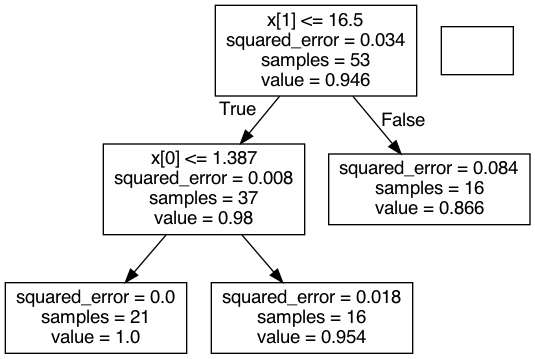

In [19]:
#Визуализация текущей модели оценки потерь при списании 

dot_data_1 = tree.export_graphviz(clf_1,out_file=None);
graph_1 = pydotplus.graph_from_dot_data(dot_data_1);
Image(graph_1.create_png())

In [21]:
#Кросс-валидация модели оценки потерь при списании

max_int_1 = 11;
cv_scores_1 = [];

for i in range (1, max_int_1):
    d_tree_1 = tree.DecisionTreeRegressor(max_depth = i, min_samples_leaf = 12, min_impurity_decrease = 0.000001)
    scores_1 = cross_val_score(d_tree_1,pd.DataFrame(np.array([a1.x9,a1.x12]).transpose()),a1.LGD_target, cv = 4, scoring = 'r2')
    cv_scores_1.append(scores_1.mean())
    
print("Значения коэффициента r2 на кросс-валидации для решающего дерева =",cv_scores_1);
best = 2 #оптимальное значение коэффициента r2 на кросс-валидации
print("Оптимальная глубина дерева =", best)

Значения коэффициента r2 на кросс-валидации для решающего дерева = [-0.7668190945824489, -0.84240640192942, -0.8494485053650134, -0.8478487670956867, -0.84240640192942, -0.8494485053650134, -0.8478487670956867, -0.8440061401987466, -0.8440061401987466, -0.8440061401987466]
Оптимальная глубина дерева = 2


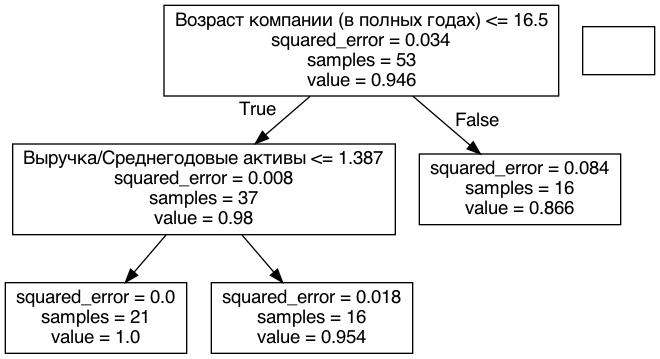

In [23]:
#Итоговое дерево модели оценки потерь при списании

dot_data_1 = tree.export_graphviz(clf_1,out_file=None,feature_names=['Выручка/Среднегодовые активы','Возраст компании (в полных годах)']);
graph_1 = pydotplus.graph_from_dot_data(dot_data_1);
Image(graph_1.create_png())

In [24]:
#Характеристики итоговой модели оценки потерь при списании
print("Количество наблюдений в исходной выборке =", a1.x1.shape[0]);
print("Значимость весов риск-факторов в модели =",clf_fit_1.feature_importances_);
print("Значение коэффициента Somers'D модели =", somers_d(pd.DataFrame(clf_fit_1.predict(rsh_1)),a1.LGD_target,weight = None));
print("Значение коэффициента r2 модели =", clf_fit_score_1);
print("Значение коэффициента r2 на кросс-валидации =",cv_scores_1[0]);

Количество наблюдений в исходной выборке = 53
Значимость весов риск-факторов в модели = [0.11755434 0.88244566]
Значение коэффициента Somers'D модели = 0.39067055393586003
Значение коэффициента r2 модели = 0.09159800605917179
Значение коэффициента r2 на кросс-валидации = -0.7668190945824489


In [47]:
#Применение комбинированной модели LGD
p_spis = clf_fit.predict_proba(rsh)[:,1];
LGD_spis = np.array(np.where(a.x12 <= clf_fit_1.tree_.threshold[0], clf_fit_1.tree_.value[1], clf_fit_1.tree_.value[2])).transpose()[:,0];
LGD_final = np.array(p_spis*LGD_spis);
print(LGD_final);

[0.36465771 0.28452124 0.28452124 0.28452124 0.36465771 0.18148474
 0.28452124 0.28452124 0.37208741 0.37208741 0.36465771 0.36465771
 0.78946177 0.77369811 0.18148474 0.18518239 0.36465771 0.4900088
 0.18518239 0.4900088  0.18148474 0.2903182  0.49999245 0.36465771
 0.36465771 0.18148474 0.4900088  0.4900088  0.36465771 0.36465771
 0.77369811 0.18518239 0.36465771 0.49999245 0.28452124 0.28452124
 0.18148474 0.18148474 0.18148474 0.36465771 0.77369811 0.28452124
 0.36465771 0.18148474 0.77369811 0.4900088  0.36465771 0.37208741
 0.36465771 0.18148474 0.18148474 0.18148474 0.78946177 0.18148474
 0.4900088  0.28452124 0.2903182  0.18148474 0.36465771 0.18148474
 0.36465771 0.36465771 0.28452124 0.36465771 0.77369811 0.28452124
 0.18148474 0.77369811 0.36465771 0.18148474 0.36465771 0.28452124
 0.77369811 0.28452124 0.36465771 0.18148474 0.36465771 0.18518239
 0.4900088  0.78946177 0.28452124 0.78946177 0.78946177 0.36465771
 0.28452124 0.28452124 0.78946177 0.49999245 0.37208741 0.37208

In [48]:
#Формирование бутстрапов для тестирования финальной модели
sd_b_1_0 = pd.DataFrame(np.array([a.Bootstrap,LGD_final,a.LGD_target]).transpose());
sd_b_1 = sd_b_1_0[sd_b_1_0[0] == 1]
sd_b_2_0 = pd.DataFrame(np.array([a.Bootstrap,LGD_final,a.LGD_target]).transpose());
sd_b_2 = sd_b_2_0[sd_b_2_0[0] == 2]
sd_b_3_0 = pd.DataFrame(np.array([a.Bootstrap,LGD_final,a.LGD_target]).transpose());
sd_b_3 = sd_b_3_0[sd_b_3_0[0] == 3]
sd_b_4_0 = pd.DataFrame(np.array([a.Bootstrap,LGD_final,a.LGD_target]).transpose());
sd_b_4 = sd_b_4_0[sd_b_4_0[0] == 4]

In [49]:
#Характеристики итоговой модели LGD
print("Количество наблюдений в исходной выборке =", a.x1.shape[0]);
print("Значение коэффициента Somers'D модели =", somers_d(LGD_final,a.LGD_target,weight = None));
print("Среднее значение коэффициента Somers'D модели на бутстрапах =",np.mean([somers_d(sd_b_1[1],sd_b_1[2],weight = None),somers_d(sd_b_2[1],sd_b_2[2],weight = None),somers_d(sd_b_3[1],sd_b_3[2],weight = None),somers_d(sd_b_4[1],sd_b_4[2],weight = None)]));
print("Значение коэффициента корреляции Спирмена модели =", stats.spearmanr(LGD_final,a.LGD_target)[0]);
print("Среднее значение коэффициента Спирмена модели на бутстрапах =",np.mean([stats.spearmanr(sd_b_1[1],sd_b_1[2])[0],stats.spearmanr(sd_b_2[1],sd_b_2[2])[0],stats.spearmanr(sd_b_3[1],sd_b_3[2])[0],stats.spearmanr(sd_b_4[1],sd_b_4[2])[0]]));
print("Значение коэффициента r2 модели =", metrics.r2_score(a.LGD_target, LGD_final));
print("Среднее значение коэффициента r2 модели на бутстрапах =",np.mean([metrics.r2_score(sd_b_1[2], sd_b_1[1]),metrics.r2_score(sd_b_2[2], sd_b_2[1]),metrics.r2_score(sd_b_3[2], sd_b_3[1]),metrics.r2_score(sd_b_4[2], sd_b_4[1])]));
print("Значение статистики для Loss Shortfall test =", 1 - (sum(LGD_final*np.array(a.DNW_D))/sum(a.LGD_target*np.array(a.DNW_D))));
print("Значение статистики для MAD test =", sum(abs(a.LGD_target - LGD_final)*np.array(a.DNW_D))/sum(np.array(a.DNW_D)));


Количество наблюдений в исходной выборке = 136
Значение коэффициента Somers'D модели = 0.3517503163222269
Среднее значение коэффициента Somers'D модели на бутстрапах = 0.35171995622828256
Значение коэффициента корреляции Спирмена модели = 0.32322251747927233
Среднее значение коэффициента Спирмена модели на бутстрапах = 0.30624006859930686
Значение коэффициента r2 модели = 0.11377787302004405
Среднее значение коэффициента r2 модели на бутстрапах = 0.03926003268861547
Значение статистики для Loss Shortfall test = -0.7289548563543078
Значение статистики для MAD test = 0.37111816701672035


In [ ]:
#Выгрузка значений LGD по итоговой модели
zz_load = pd.DataFrame(np.array([p_spis,LGD_spis,LGD_final]).transpose());
zz_load.to_excel(excel_writer = "LGD_comb_podh_res.xlsx",header=['p_spis','LGD_spis','LGD_final']);